In [1]:
import os
import math
import pickle
import numpy as np
import pandas as pd
import datetime as dt
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from itertools import cycle
from sklearn.utils import shuffle
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, \
                            r2_score, mean_poisson_deviance, mean_gamma_deviance, accuracy_score 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Without Features

In [20]:
df_usdt = pd.read_csv('USDT.csv')
df_usdt['Date'] = pd.to_datetime(df_usdt['Date'])
df_usdt = df_usdt[['Date','Close']]
df_usdt = df_usdt[df_usdt['Date'] > '2018-01-01']
df_usdt = df_usdt.dropna()
btc_stock = df_usdt.copy()
btc_stock

,Date,Close
54,2018-01-02,1.004900
55,2018-01-03,1.013440
56,2018-01-04,1.002530
57,2018-01-05,0.998634
58,2018-01-06,1.008990
...,...,...
1841,2022-11-24,0.999421
1842,2022-11-25,0.999578
1843,2022-11-26,0.999574
1844,2022-11-27,0.999604


In [21]:
del df_usdt['Date']
scaler = MinMaxScaler(feature_range=(0,1))
df_usdt = scaler.fit_transform(np.array(df_usdt).reshape(-1,1))

In [22]:
# split dataset into train and test split
training_size = int(len(df_usdt)*0.8)
test_size = len(df_usdt) - training_size

train_data, test_data = df_usdt[0:training_size,:], df_usdt[training_size:len(df_usdt),:1]

In [23]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
time_step = 15
X_train_wof, y_train_wof = create_dataset(train_data, time_step)
X_test_wof, y_test_wof = create_dataset(test_data, time_step)

print("X_train: ", X_train_wof.shape)
print("y_train: ", y_train_wof.shape)
print("X_test: ", X_test_wof.shape)

X_train:  (1417, 15)
y_train:  (1417,)
X_test:  (343, 15)


In [25]:
X_train_wof = X_train_wof.reshape(X_train_wof.shape[0],X_train_wof.shape[1] , 1)
X_test_wof = X_test_wof.reshape(X_test_wof.shape[0],X_test_wof.shape[1] , 1)

print("X_train: ", X_train_wof.shape)
print("X_test: ", X_test_wof.shape)

X_train:  (1417, 15, 1)
X_test:  (343, 15, 1)


In [26]:
model_wof=Sequential()
model_wof.add(LSTM(10,input_shape=(None,1),activation="relu"))
model_wof.add(Dense(1))
model_wof.compile(loss="mean_squared_error",optimizer="sgd")
history = model_wof.fit(
                    X_train_wof,
                    y_train_wof,
                    validation_data=(X_test_wof,y_test_wof),
                    epochs=200,
                    batch_size=32,
                    verbose=1
                    )
model_wof.evaluate(X_test_wof, y_test_wof)

Epoch 1/200
45/45 [==============================] - 4s 61ms/step - loss: 0.0647 - val_loss: 0.0091
Epoch 2/200
45/45 [==============================] - 3s 58ms/step - loss: 0.0085 - val_loss: 1.5325e-04
Epoch 3/200
45/45 [==============================] - 3s 57ms/step - loss: 0.0041 - val_loss: 1.4672e-04
Epoch 4/200
45/45 [==============================] - 3s 57ms/step - loss: 0.0038 - val_loss: 3.2766e-04
Epoch 5/200
45/45 [==============================] - 3s 57ms/step - loss: 0.0037 - val_loss: 3.7115e-04
Epoch 6/200
45/45 [==============================] - 3s 57ms/step - loss: 0.0037 - val_loss: 3.2599e-04
Epoch 7/200
45/45 [==============================] - 3s 56ms/step - loss: 0.0037 - val_loss: 3.7047e-04
Epoch 8/200
45/45 [==============================] - 3s 56ms/step - loss: 0.0037 - val_loss: 3.4724e-04
Epoch 9/200
45/45 [==============================] - 3s 56ms/step - loss: 0.0037 - val_loss: 3.7661e-04
Epoch 10/200
45/45 [==============================] - 3s 57ms/step -

0.00012037358828820288

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# With Features

In [4]:
df_usdt = pd.read_csv('USDT.csv')
df_usdt['Date'] = pd.to_datetime(df_usdt['Date'])
df_usdt = df_usdt[['Date','Open','High','Low','Close']]
df_usdt = df_usdt[df_usdt['Date'] > '2018-01-01']
df_usdt = df_usdt.dropna()
btc_stock = df_usdt.copy()
btc_stock

,Date,Open,High,Low,Close
54,2018-01-02,1.005740,1.009880,0.993250,1.004900
55,2018-01-03,1.006600,1.023280,1.002640,1.013440
56,2018-01-04,1.013200,1.016180,0.993822,1.002530
57,2018-01-05,1.001750,1.005010,0.985915,0.998634
58,2018-01-06,1.000280,1.012090,0.996847,1.008990
...,...,...,...,...,...
1841,2022-11-24,0.999191,0.999507,0.999123,0.999421
1842,2022-11-25,0.999417,0.999590,0.999404,0.999578
1843,2022-11-26,0.999577,0.999626,0.999507,0.999574
1844,2022-11-27,0.999568,0.999654,0.999503,0.999604


In [5]:
del df_usdt['Date']
scaler = MinMaxScaler(feature_range=(0,1))
df_usdt = scaler.fit_transform(df_usdt)

with open('scaler USDT.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [29]:
# split dataset into train and test split
training_size = int(len(df_usdt)*0.8)
test_size = len(df_usdt) - training_size

train_data, test_data = df_usdt[0:training_size,:], df_usdt[training_size:len(df_usdt),]

In [30]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step,-1])
    return np.array(dataX), np.array(dataY)

In [31]:
time_step = 15
X_train_wf, y_train_wf = create_dataset(train_data, time_step)
X_test_wf, y_test_wf = create_dataset(test_data, time_step)

print("X_train: ", X_train_wf.shape)
print("y_train: ", y_train_wf.shape)
print("X_test: ", X_test_wf.shape)
print("y_test: ", y_test_wf.shape)

X_train:  (1417, 15, 4)
y_train:  (1417,)
X_test:  (343, 15, 4)
y_test:  (343,)


In [32]:
model_wf=Sequential()
model_wf.add(LSTM(10,input_shape=(None,4),activation="relu"))
model_wf.add(Dense(1))
model_wf.compile(loss="mean_squared_error",optimizer="adam")
history = model_wf.fit(
                    X_train_wf,
                    y_train_wf,
                    validation_data=(X_test_wf,y_test_wf),
                    epochs=200,
                    batch_size=32,
                    verbose=1
                    )
model_wf.evaluate(X_test_wf, y_test_wf)

Epoch 1/200
45/45 [==============================] - 4s 66ms/step - loss: 0.1278 - val_loss: 0.0597
Epoch 2/200
45/45 [==============================] - 2s 55ms/step - loss: 0.0248 - val_loss: 1.6856e-04
Epoch 3/200
45/45 [==============================] - 3s 57ms/step - loss: 0.0025 - val_loss: 1.8032e-04
Epoch 4/200
45/45 [==============================] - 3s 59ms/step - loss: 0.0022 - val_loss: 2.6286e-04
Epoch 5/200
45/45 [==============================] - 2s 52ms/step - loss: 0.0021 - val_loss: 7.6057e-05
Epoch 6/200
45/45 [==============================] - 2s 55ms/step - loss: 0.0021 - val_loss: 6.5823e-05
Epoch 7/200
45/45 [==============================] - 3s 56ms/step - loss: 0.0021 - val_loss: 7.0073e-05
Epoch 8/200
45/45 [==============================] - 3s 57ms/step - loss: 0.0020 - val_loss: 7.9847e-05
Epoch 9/200
45/45 [==============================] - 2s 55ms/step - loss: 0.0020 - val_loss: 1.7093e-04
Epoch 10/200
45/45 [==============================] - 2s 55ms/step -

1.9062750652665272e-05

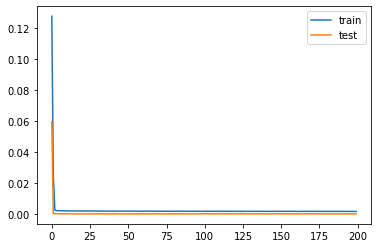

In [33]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [34]:
model_wf.save('model_wf USDT.h5')
model_wof.save('model_wof USDT.h5')